# Hybrid Search for E-Commerce with Pinecone


By combining the strengths of traditional text-based search algorithms with the visual recognition capabilities of deep learning models, hybrid vector search allows users to search for products using a combination of text and images. This can be especially useful for product searches, where customers may not know the exact name or details of the item they are looking for.


## Install Dependencies

In [ ]:
!pip install -qU datasets transformers sentence-transformers \
                 pinecone-client==3.1.0 pinecone-text \
                 pinecone-notebooks

## Connect to Pinecone

In [ ]:
from pinecone_notebooks.colab import Authenticate

Authenticate()

In [ ]:
import os
from pinecone import Pinecone

# initialize connection to pinecone
api_key = os.environ.get('pcsk_2XvhS_F8DBNuXvffNAUVDRnYUccr21mwaPQ7Xwpa7wJLW8Ztgp8a2jpGeQKVMFJ4THENJ')

# configure client
pc = Pinecone(api_key=api_key)

In [ ]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [ ]:
# choose a name for your index
index_name = "hybrid-image-search"

In [ ]:
import time

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=512,
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

# Load Dataset

We will work with a subset of the [Open Fashion Product Images](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small) dataset, consisting of ~44K fashion products with images and category labels describing the products. The dataset can be loaded from the Huggigface Datasets hub as follows:

In [ ]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

We will first assign the images and metadata into separate variables and then convert the metadata into a pandas dataframe.

In [ ]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

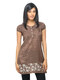

In [ ]:
# display a product image
images[900]

In [ ]:
images[900].save("product_image.png")
print("Image saved as 'product_image.png'")

Image saved as 'product_image.png'


In [ ]:
# convert metadata into a pandas dataframe
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


We need both sparse and dense vectors to perform hybrid search. We will use all the metadata fields except for the `id` and `year` to create sparse vectors and the product images to create dense vectors.

## Sparse Vectors

To create the sparse vectors we'll use BM25. We import the BM25 function from the [`pinecone-text` library](https://github.com/pinecone-io/pinecone-text).

In [ ]:
from pinecone_text.sparse import BM25Encoder

bm25 = BM25Encoder()

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

The tokenization will look something like this:

In [ ]:
"Turtle Check Men Navy Blue Shirt".lower().split()

['turtle', 'check', 'men', 'navy', 'blue', 'shirt']

BM25 requires training on a representative portion of the dataset. We do this like so:

In [ ]:
bm25.fit(metadata['productDisplayName'])

  0%|          | 0/44072 [00:00<?, ?it/s]

Let's create a test sparse vector using a `productDisplayName`.

In [ ]:
metadata['productDisplayName'][0]

'Turtle Check Men Navy Blue Shirt'

In [ ]:
bm25.encode_queries(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.3276687848622804,
  0.19377339510596148,
  0.040475545164610806,
  0.1808640794607714,
  0.10791423980552016,
  0.1493039556008558]}

And for the stored docs, we only need the "IDF" part:

In [ ]:
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

## Dense Vectors

We will use the CLIP to generate dense vectors for product images. We can directly pass PIL images to CLIP as it can encode both images and texts. We can load CLIP like so:

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

SentenceTransformer(
  (0): CLIPModel()
)

In [ ]:
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

(1, 512)

The model gives us a `512` dimensional dense vector.

## Upsert Documents

Now we can go ahead and generate sparse and dense vectors for the full dataset and upsert them along with the metadata to the new hybrid index. We can do that easily as follows:

In [ ]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

  0%|          | 0/221 [00:00<?, ?it/s]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

In [ ]:
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

## Querying

Now we can query the index, providing the sparse and dense vectors. We do this directly with an equal weighting between sparse and dense like so:

## Using Query

In [ ]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


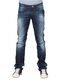
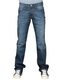
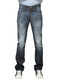
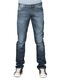
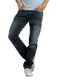

In [ ]:
query = "dark blue french connection jeans for men"

# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

result = index.query(
    top_k=5,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
# imgs
display_result(imgs)

## Image search

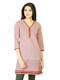

In [ ]:
images[36254]


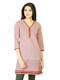
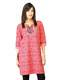
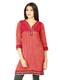
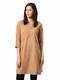
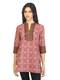

In [ ]:
image_to_search = images[36254]
dense = model.encode(image_to_search).tolist()

result = index.query(
    top_k=5,
    vector=dense,
    include_metadata=True
)


imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

It's possible to prioritize our search based on sparse vs. dense vector results. To do so, we scale the vectors, for this we'll use a function named `hybrid_scale`.

In [ ]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

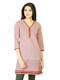

In [ ]:
images[36254]

Our "purple" component isn't being considered strongly enough, let's add this to the metadata filtering:


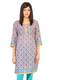
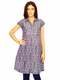
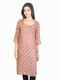
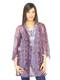
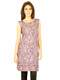
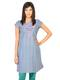
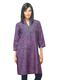
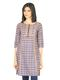
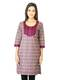
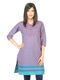
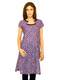
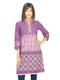
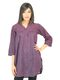
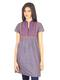

In [ ]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Purple"}
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Let's try with another image:

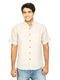

In [ ]:
images[36256]


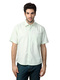
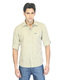
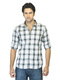
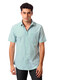
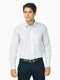
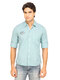
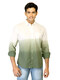
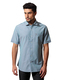
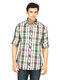
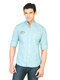
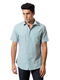
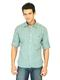
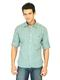
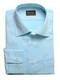

In [ ]:
query = "soft green color topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36256]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.6)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Green"}  # add to metadata filter
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

# Delete the Index

If you're done with the index, we delete it to save resources.

In [1]:
# pc.delete_index(index_name)

# Virtual Try-on


In [2]:
!pip install gradio_client requests pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 8.0 MB/s eta 0:00:00


Loaded as API: https://nymbo-virtual-try-on.hf.space ✔


/usr/local/lib/python3.10/dist-packages/gradio_client/utils.py:1124: UserWarning: file() is deprecated and will be removed in a future version. Use handle_file() instead.
  warnings.warn(


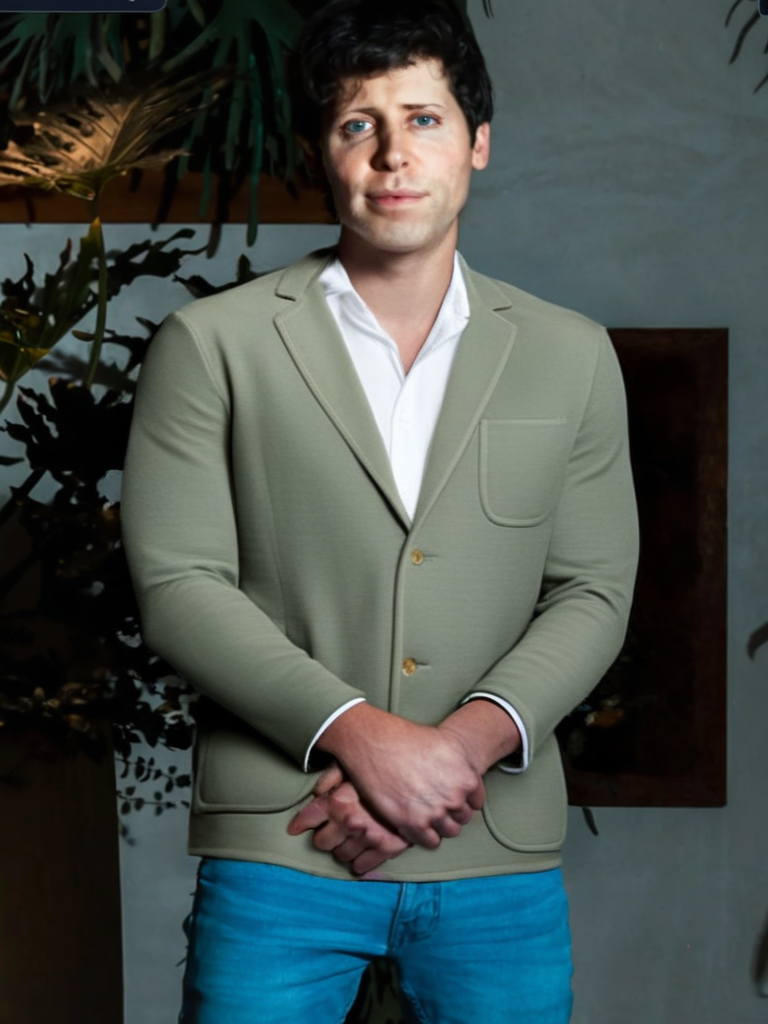

In [3]:
from gradio_client import Client, file
from PIL import Image
import requests

client = Client("Nymbo/Virtual-Try-On")


person_image_path = "/content/person.png"   # path to person image
garment_image_path = "/content/garment.png" # path to garment image

result = client.predict(
    dict(background=file(person_image_path), layers=[], composite=None),
    garm_img=file(garment_image_path),
    garment_des="A cool description of the garment",
    is_checked=True,
    is_checked_crop=False,
    denoise_steps=30,
    seed=42,
    api_name="/tryon"
)

if result and len(result) > 0:
    output_image_path = result[0]
    # Load and display the output image
    output_image = Image.open(output_image_path)
    output_image.save("output_try_on.png")  # Save locally
    display(output_image)
else:
    print("No result returned from the API.")


---